In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [2]:
import ktrain
from ktrain import text

In [3]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from IPython.display import Markdown
from IPython.display import display

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [4]:
import json

data = json.load(open("./data/dataset.json", "r"))

data = pd.DataFrame(data)
data.sample(10)

,text,author_id,label,created_at,retweet_count,reply_count,like_count,quote_count,in_reply_to_user_id
53275,The prolonged use of medical masks* when prope...,964949498,real,2020-06-13T06:13:40.000Z,3,0,8,0,True
241987,@XXELiteTURkey @FraiseAdam @stamford_dan @E91_...,19927339,real,2020-04-28T15:06:23.000Z,0,1,0,0,False
20053,Guidance for Cleaning and Disinfecting https:/...,826283663658737666,real,2020-05-08T12:31:07.000Z,3,0,0,0,True
32540,"COVID-19 Daily: New Study Tracks US Response, ...",20057016,real,2020-05-04T19:30:11.000Z,0,0,0,0,True
35846,#VACCINE #WAITINGFORGODOT\n'Pfizer: COVID-19 V...,1575659701,real,2020-05-14T22:37:29.000Z,0,0,0,0,True
150306,Portable AI Device Turns Coughing Sounds into ...,93417622,real,2020-03-21T10:08:24.000Z,0,0,0,0,True
252172,@pagetsam I don't want anyone to be on my side...,409941783,real,2020-05-01T22:10:41.000Z,0,2,0,0,False
97915,@GuyOpperman Our thoughts are with you and all...,1089231518160044033,real,2020-07-01T09:01:10.000Z,0,0,0,0,False
21793,New adjuvant successful in extending immunity ...,21558596,real,2020-06-21T09:37:26.000Z,3,0,2,0,True
136932,New coronavirus stable for hours on surfaces h...,160734860,real,2020-03-26T05:35:15.000Z,1,0,0,0,True


In [5]:
test_data = data.groupby("label").sample(frac=0.2)
data = data.drop(index=test_data.index)

In [7]:
data.text.str.split().apply(len).describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

count    177151.000000
mean         25.556926
std          14.728556
min           1.000000
25%          12.000000
50%          23.000000
75%          38.000000
90%          46.000000
95%          50.000000
max         106.000000
Name: text, dtype: float64

In [8]:
data.label.value_counts()

real    168620
fake      8531
Name: label, dtype: int64

In [9]:
trn, val, preproc = text.texts_from_df(
    data,
    text_column = "text",
    label_columns="label",
    maxlen=50,
    ngram_range=1,
    random_state=41,
    preprocess_mode="standard"
)

['fake', 'real']
        fake  real
80978    0.0   1.0
14424    0.0   1.0
216659   0.0   1.0
41885    0.0   1.0
23087    0.0   1.0
['fake', 'real']
        fake  real
208413   0.0   1.0
37163    0.0   1.0
77548    0.0   1.0
151794   0.0   1.0
19242    0.0   1.0
language: en
Word Counts: 249888
Nrows: 159435
159435 train sequences
train sequence lengths:
	mean : 26
	95percentile : 49
	99percentile : 54
x_train shape: (159435,50)
y_train shape: (159435, 2)
Is Multi-Label? False
17716 test sequences
test sequence lengths:
	mean : 26
	95percentile : 49
	99percentile : 54
x_test shape: (17716,50)
y_test shape: (17716, 2)


In [10]:
model = text.text_classifier('logreg', trn , preproc=preproc)

Is Multi-Label? False
compiling word ID features...
maxlen is 50
done.


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 50, 2)        40000       ['input_1[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 50, 1)        20000       ['input_1[0][0]']                
                                                                                                  
 dot (Dot)                      (None, 2, 1)         0           ['embedding_1[0][0]',            
                                                                  'embedding[0][0]']          

In [12]:
learner = ktrain.get_learner(model, 
                             train_data=trn, 
                             val_data=val, 
                             batch_size=128)

In [13]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
1246/1246 [==============================] - 2s 1ms/step - loss: 0.4958 - accuracy: 0.7742
Epoch 2/1024
1246/1246 [==============================] - 1s 470us/step - loss: 0.5844 - accuracy: 0.9620


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


Three possible suggestions for LR from plot:
	Longest valley (red): 2.08E-04
	Min numerical gradient (purple): 1.80E-02
	Min loss divided by 10 (omitted from plot): 2.08E-02


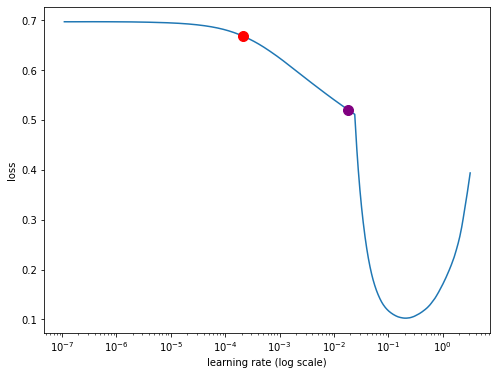

In [14]:
learner.lr_plot(suggest=True)

In [15]:
import gc
gc.collect()

15340

In [16]:
# 2e-5 is one of the LRs  recommended by Google and is consistent with the plot above.
learner.fit_onecycle(2.08E-04, 10)



begin training using onecycle policy with max lr of 0.000208...
Epoch 1/10
1246/1246 [==============================] - 2s 1ms/step - loss: 0.4800 - accuracy: 0.9224 - val_loss: 0.3161 - val_accuracy: 0.9517
Epoch 2/10
1246/1246 [==============================] - 2s 1ms/step - loss: 0.2525 - accuracy: 0.9519 - val_loss: 0.2095 - val_accuracy: 0.9530
Epoch 3/10
1246/1246 [==============================] - 2s 1ms/step - loss: 0.1894 - accuracy: 0.9535 - val_loss: 0.1727 - val_accuracy: 0.9558
Epoch 4/10
1246/1246 [==============================] - 2s 1ms/step - loss: 0.1592 - accuracy: 0.9608 - val_loss: 0.1487 - val_accuracy: 0.9642
Epoch 5/10
1246/1246 [==============================] - 2s 1ms/step - loss: 0.1370 - accuracy: 0.9677 - val_loss: 0.1302 - val_accuracy: 0.9697
Epoch 6/10
1246/1246 [==============================] - 2s 1ms/step - loss: 0.1206 - accuracy: 0.9715 - val_loss: 0.1187 - val_accuracy: 0.9718
Epoch 7/10
1246/1246 [==============================] - 2s 2ms/step - 

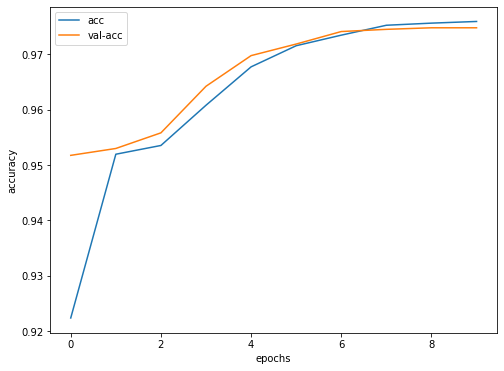

In [17]:
plt.plot(learner.history.history["accuracy"])
plt.plot(learner.history.history["val_accuracy"])
plt.legend(["acc", "val-acc"])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

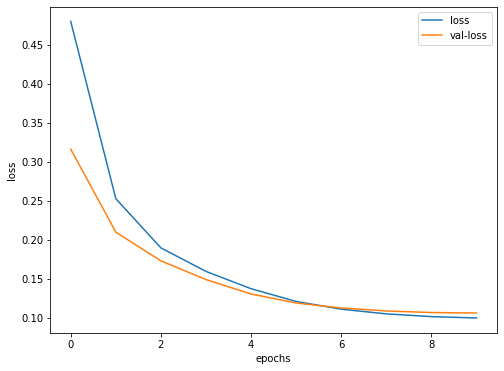

In [18]:
plt.plot(learner.history.history["loss"])
plt.plot(learner.history.history["val_loss"])
plt.legend(["loss", "val-loss"])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [19]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [20]:
probs = predictor.predict_proba(test_data["text"].values)
probs[:5]

array([[0.2843219 , 0.7156781 ],
       [0.39816812, 0.60183185],
       [0.97159123, 0.02840879],
       [0.74573547, 0.2542645 ],
       [0.8886261 , 0.11137389]], dtype=float32)

In [21]:
y = (test_data.label == "fake")
y.head()

193047    True
181937    True
191933    True
51948     True
194849    True
Name: label, dtype: bool

In [22]:
import metrics as mmetrics

In [23]:
y = y.values.reshape((-1, 1))

perfs = mmetrics.get_performance_metrics(y, probs[:, :1], ["LogREG"])
perfs

,TP,TN,FP,FN,Accuracy,Prevalence,Sensitivity,Specificity,PPV,NPV,AUC,F1,Threshold
,,,,,,,,,,,,,
LogREG,1121,42043,112,1012,0.975,0.048,0.526,0.997,0.909,0.976,0.926,0.666,0.5
